## RNA decay plots
Author: Robert Ietswaart, 20200402
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.
Python v3.7.4 

For Erik's project: aim is to visualize 1 and 2 state RNA decay models and provide %new.

Starting point references: theory from McShane et al, Cell 2016. Sin et al, PLoS ONE, 2016.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns

# import os.path as osp
# import math
# import copy
# import re
# import pickle as pkl

### Define 1 and 2 state functions

In [218]:
def Lam1state(k,t):
    """ Model includes 4sU dynamics: derivations by Robert Ietswaart, N6p63-80
        t: time
        kout: 4sU/U exchange out rate
        kA: RNA degradation rate from state A
    """
    kout = k[0]
    kA = k[1]
    Lambda = -kA/(kout-kA)*(1 - np.exp(-kout * t)) + \
              kout/(kout-kA)*(1 - np.exp(-kA * t))
    return Lambda

def Lam2state(k,t):
    """ Model includes 4sU dynamics: derivations by Robert Ietswaart, N6p63-80
        t: time
        kout: 4sU/U exchange out rate
        kA: RNA degradation rate from state A
        kAB: transition rate from state A to state B
        kB: RNA degradation rate from state B
    """
    kout = k[0]
    kA = k[1]
    kAB = k[2]
    kB = k[3]
    Phi = kB*(kA+kAB)*(kB+kAB-kout)/((kB+kAB)*(kA+kAB-kout)*(kB-kout))
    Psi = kB*(kA-kB)*kout/((kB+kAB)*(kout-(kA+kAB))*(kA+kAB-kB))
    Omega = kAB*kout*(kA+kAB)/((kB+kAB)*(kA+kAB-kB)*(kout-kB))#1-Phi-Psi
    Lambda = Phi*(1 - np.exp(-kout * t)) + \
             Psi*(1 - np.exp(-(kA+kAB) * t)) + \
             Omega*(1 - np.exp(-kB * t))
#     print(Phi+Psi+Omega)
    return Lambda

def Lam1state_toy_model(k,t):
    """ Model without 4sU dynamics
        t: time
        kA: RNA degradation rate from state A
        Derived in Sin et al, PLoS ONE 2016
    """
    kA = k[1]
    Lambda = 1 - np.exp(-kA * t)
    return Lambda

def Lam2state_toy_model(k,t):
    """ Model without 4sU dynamics
        t: time
        kA: RNA degradation rate from state A
        kAB: transition rate from state A to state B
        kB: RNA degradation rate from state B
        Derived in Sin et al, PLoS ONE 2016: eq 19
    """
    kA = k[1]
    kAB = k[2]
    kB = k[3]
    Ap = kB*(kA-kB)
    Bp = kAB*(kA+kAB)
    Lambda = Ap/(Ap+Bp)*(1 - np.exp(-(kA+kAB) * t)) + \
             Bp/(Ap+Bp)*(1 - np.exp(-kB * t))
    return Lambda

### Time point definitions
units: minutes

In [219]:
time_measured = pd.Series([0,15,30,60,120,240]) 
T_max = 300
time_all = pd.Series(range(0,T_max)) #for plotting continuous curves

### Set parameters
units: min^-1  
k = [kout,kA,kAB,kB]  = [1/Tout, 1/TA, 1/TAB, 1/TB]  
in 1 state model: only kout and kA are used  
for simplicity and intuition: set the time scales (units: mins): inverse of rates 

In [225]:
Tout = 10

TA1 = 3*60
k_1state = [1.0/Tout, 1.0/TA1] 

TA2 = 20
TAB = 60
TB = 3*60
k_2state = [1.0/Tout, 1.0/TA2, 1.0/TAB, 1.0/TB] 

In [226]:
# np.exp(-5.3*time_all)
# 5.3*time_all
# -k[1]/(k[0]-k[1])*(1 - np.exp(-k[0] * time_measured))

### Calculate New to Total RNA (NTR) curves

In [227]:
NTR1_all = Lam1state(k_1state,time_all)
NTR1_measured = Lam1state(k_1state,time_measured)
NTR1_toy_all = Lam1state_toy_model(k_1state,time_all)
NTR1_toy_measured = Lam1state_toy_model(k_1state,time_measured)
NTR2_all = Lam2state(k_2state,time_all)
NTR2_measured = Lam2state(k_2state,time_measured)
NTR2_toy_all = Lam2state_toy_model(k_2state,time_all)
NTR2_toy_measured = Lam2state_toy_model(k_2state,time_measured)

### Output fractions NTR

In [228]:
output = pd.DataFrame()
output['time'] = time_measured
output['NTR_1state'] = NTR1_measured
output['NTR_2state'] = NTR2_measured
output

,time,NTR_1state,NTR_2state
0,0,0.000000,0.000000
1,15,0.038961,0.094172
2,30,0.106654,0.213366
3,60,0.241466,0.370292
4,120,0.456382,0.555041
5,240,0.720897,0.771643


### Visualization of models (with and w/o 4sU dynamics)

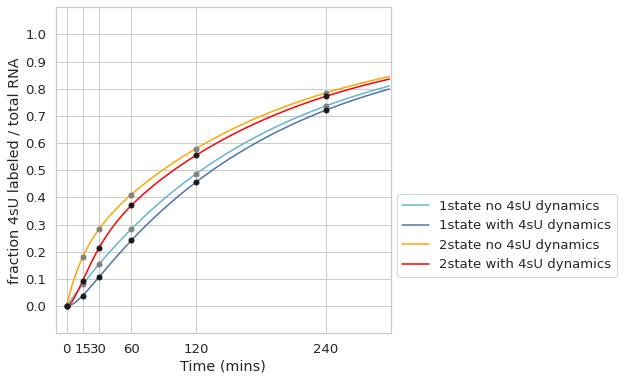

In [230]:
sns.set(style="whitegrid", color_codes=True,font_scale=1.2)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=time_all, y=NTR1_toy_all, color='c') 
ax.errorbar(x=time_all, y=NTR1_all, color='b') 
ax.errorbar(x=time_all, y=NTR2_toy_all, color='orange')
ax.errorbar(x=time_all, y=NTR2_all, color='red') 
ax.errorbar(x=time_measured, y=NTR1_toy_measured, 
            fmt='o', ms=5,color='grey') 
ax.errorbar(x=time_measured, y=NTR1_measured, 
            fmt='o', ms=5,color='k') 
ax.errorbar(x=time_measured, y=NTR2_toy_measured, 
            fmt='o', ms=5,color='grey') 
ax.errorbar(x=time_measured, y=NTR2_measured, 
            fmt='o', ms=5,color='k') 


plt.xlim([-10,T_max])
plt.ylim([-0.1,1.1])
plt.xticks(time_measured)
plt.yticks([i*0.1 for i in range(11)])
plt.xlabel('Time (mins)')
plt.ylabel('fraction 4sU labeled / total RNA')
ax.legend(['1state no 4sU dynamics',
           '1state with 4sU dynamics',
           '2state no 4sU dynamics',
           '2state with 4sU dynamics'],
          loc='center left', bbox_to_anchor=(1, 0.3))
# ax.set(xscale="log")
# ax.set(yscale="log") 


# OLD scraps